# Importing packages and loading data

In [112]:
# Import packages
import pandas as pd
import math
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sb 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor 
from sklearn.linear_model import LinearRegression, Lasso, Ridge 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae 

path = 'export.xml'

# Create element tree object
tree = ET.parse(path)
root = tree.getroot()

# Load and Parse Data

Set important variables, declare models used, and define functions to be used across both BasalEnergyBurned and ActiveEnergyBurned

In [113]:
start_date = '2023-03-19' # day I started wearing Apple Watch
record_corr = 0.1 # minimum correlation required between feature and target variable for BasalEnergyBurned
workout_corr = 0.1 # minimum correlation required between feature and target variable for ActiveEnergyBurned
models = [LinearRegression(), XGBRegressor(), Lasso(), RandomForestRegressor(), Ridge()] # models to predict energy expenditure

# Feature Visualization function
def feature_visualization(continuous_features, data, target):
    n = len(continuous_features)
    fig, axes = plt.subplots(2, n, figsize=(15, 10))

    for i, f_col in enumerate(continuous_features):
        # Scatter plot to check relationship between continuous and target variable
        axes[0, i].scatter(x=f_col, y=target, data=data)

        # Density plot to check density of continuous features
        sb.histplot(data=data, x=f_col, kde=True, stat='density', ax=axes[1,i])
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,10))
    sb.heatmap(data.corr(), annot=True, cbar=True) # check correlation heatmap for feature selection
    plt.show()

# Model Training function
def find_best_model(features, output, models):
    X_train, X_val, Y_train, Y_val = train_test_split(features, output, test_size=0.4, random_state=22)

    # Perform standardization
    scaler=StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    print('------------------Daily Basal Energy Expenditure---------------------')
    print()

    for j in range(len(models)): 
        models[j].fit(X_train, Y_train)
        print(f'{models[j]} : ')
        train_preds = models[j].predict(X_train)
        print('Training Error : ', mae(Y_train, train_preds))
        
        val_preds = models[j].predict(X_val)
        print('Validation Error : ', mae(Y_val, val_preds))
        print()

# Daily Data: Basal Energy Expenditure

In [114]:
# Extract attributes for every health record
record_list = [x.attrib for x in root.iter('Record')]
record_data = pd.DataFrame(record_list) # change to dataframe

# Clean up Dataframe
record_data['Day'] = pd.to_datetime(record_data['startDate']).dt.weekday # extract day of startdate, turn to numeric
record_data['Date'] = pd.to_datetime(record_data['startDate']).dt.strftime('%Y-%m-%d') # extract date of startdate
record_data = record_data[record_data['Date'] >= start_date]
record_data['value'] = pd.to_numeric(record_data['value'], errors='coerce') # change value column to numeric
record_data['value'] = record_data['value'].fillna(1.0) # if NaN then change to occurence (1.0)
record_data['type'] = record_data['type'].str.replace('HKQuantityTypeIdentifier', '') # shorten observation name
record_data['type'] = record_data['type'].str.replace('HKCategoryTypeIdentifier', '')

# Remove unnecessary columns (remove after cleaning as you need startDate to create Date column)
remove_cols = ['sourceName', 'sourceVersion', 'device', 'startDate', 'creationDate', 'endDate']
record_data = record_data.drop(remove_cols, axis=1)

# Print type of records to see data
print(record_data['type'].unique())

['HeartRate' 'StepCount' 'DistanceWalkingRunning' 'BasalEnergyBurned'
 'ActiveEnergyBurned' 'FlightsClimbed' 'AppleExerciseTime'
 'DistanceCycling' 'DistanceSwimming' 'SwimmingStrokeCount'
 'RestingHeartRate' 'VO2Max' 'WalkingHeartRateAverage'
 'EnvironmentalAudioExposure' 'HeadphoneAudioExposure'
 'WalkingDoubleSupportPercentage' 'SixMinuteWalkTestDistance'
 'AppleStandTime' 'WalkingSpeed' 'WalkingStepLength'
 'WalkingAsymmetryPercentage' 'StairAscentSpeed' 'StairDescentSpeed'
 'AppleWalkingSteadiness' 'RunningStrideLength'
 'RunningVerticalOscillation' 'RunningGroundContactTime'
 'HeartRateRecoveryOneMinute' 'RunningPower' 'EnvironmentalSoundReduction'
 'RunningSpeed' 'AppleStandHour' 'AudioExposureEvent'
 'HeartRateVariabilitySDNN']


Based on the records, I have decided to use the following records: StepCount, DistanceWalkingRunnng, BasalEnergyBurned, AppleExerciseTime, RestingHeartRate, WalkingHeartRateAverage, AppleStandTime, HeartRateVariabilitySDNN. These records are going to be aggregated at a daily level (either by sum or average).

In [115]:
# Aggregate values daily (sum)
sum_record_list = ['StepCount', 'BasalEnergyBurned', 'AppleExerciseTime', 'AppleStandTime', 'ActiveEnergyBurned', 'DistanceWalkingRunning'] # columns to aggregate by sum
record_data_sum = record_data[record_data['type'].isin(sum_record_list)]
record_data_sum = record_data_sum.groupby(['type', 'Date', 'Day', 'unit'], as_index=False).agg({'value': 'sum'})

# Aggregate values daily (avg)
avg_record_list = ['HeartRateVariabilitySDNN', 'RestingHeartRate', 'WalkingHeartRateAverage'] # columns to aggregate by avg
record_data_avg = record_data[record_data['type'].isin(avg_record_list)]
record_data_avg = record_data_avg.groupby(['type', 'Date', 'Day', 'unit'], as_index=False).agg({'value': 'mean'})

# Concatenate above two dataframes
daily_df = pd.concat([record_data_sum, record_data_avg])
daily_df = daily_df.sort_values(['Date', 'type']) # sort by date and type of record
daily_df = daily_df[['Date', 'Day', 'type', 'value']] # rearranging columns and removing unit

# Pivot to reframe records as columns
daily_df = daily_df.pivot(index=['Date', 'Day'], columns='type', values='value')
daily_df = daily_df.rename_axis(None, axis=1).reset_index() # remove multi-indexing
daily_df = daily_df.dropna(axis=0) # remove rows where you have missing data

The following set of maps check relationships between features and target variable, and relationships inbetween features. The most valuable map is the correlation heatmap, which checks if features are correlated with the target variable and if any features are correlated. This helps with feature reduction.

If features are NOT highly correlated with the target variable, the feature does not have useful relationship and will not help with prediction.
If features are correlated, they are redundant as we can predict one from the other. Having both just increases complexity of the algorithm unnecessarily.

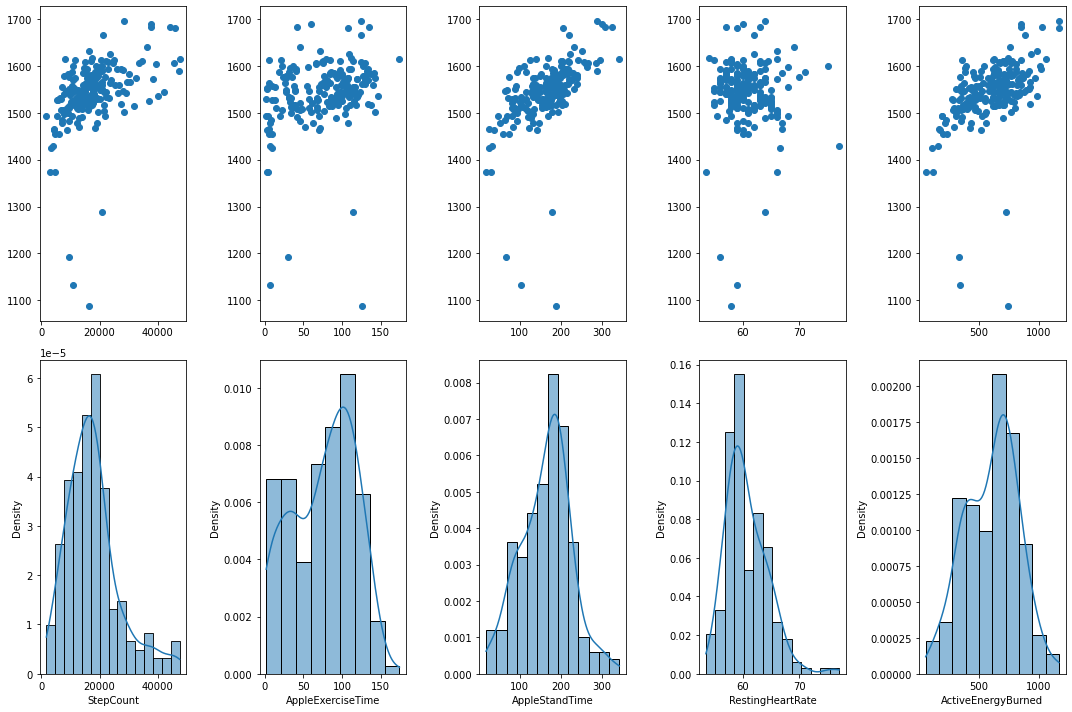

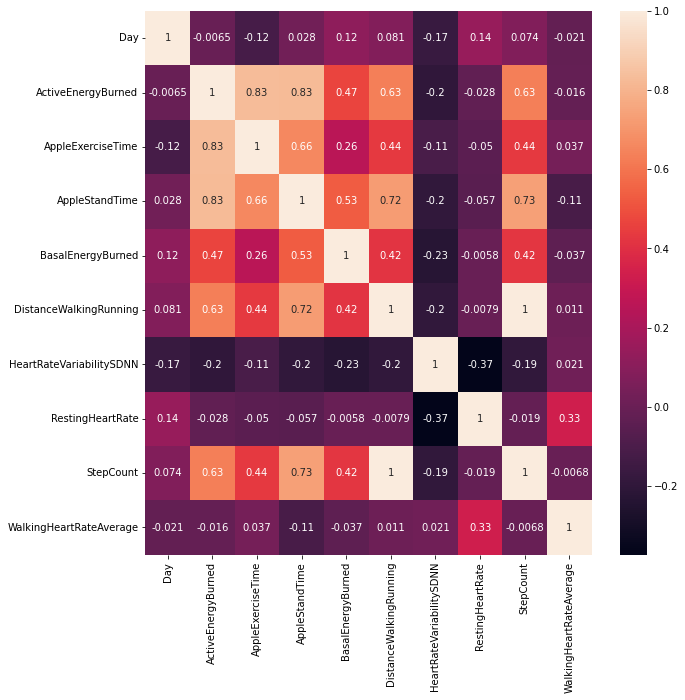

In [117]:
continuous_features = ['StepCount', 'AppleExerciseTime', 'AppleStandTime', 'RestingHeartRate', 'ActiveEnergyBurned']
feature_visualization(continuous_features, data=daily_df, target='BasalEnergyBurned')


Based on the feature correlation heatmap, RestingHeartRate and WalkingHeartRate are not as correlated with BasalEnergyBurned, so I am removing those features. Additionally, DistanceWalkingRunning and StepCount are highly correlated. DistanceWalkingRunning appears to be slightly more correlated with other features, so I will remove it from my features list.

In [118]:
# Feature selection where correlation with BasalEnergyBurned is less than record_corr
corr_values = daily_df.corr()['BasalEnergyBurned'].abs()
target_corr = corr_values.index[corr_values <= record_corr].tolist()

# Remove features that are highly correlated + target variable
redundant_var = ['DistanceWalkingRunning']
features = daily_df.drop(['Date', 'BasalEnergyBurned'] + target_corr + redundant_var, axis=1) 

# Model fitting
find_best_model(features, output=daily_df['BasalEnergyBurned'], models=models)

------------------Daily Basal Energy Expenditure---------------------

LinearRegression() : 
Training Error :  32.094511516375206
Validation Error :  30.48362881746874

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) : 
Training Error :  0.003391870117182331
Validation Error :  35.116550744628896

La

# Workout Data: Active Energy Expenditure

In [119]:
# Extract workout attributes
workout_list = list(root.iter('Workout'))

final_workout_dict = []
for i in range(len(workout_list)): # iterating through each workout
    workout_dict = workout_list[i].attrib 
    average_list = ['HeartRate', 'RunningSpeed', 'RunningPower', 'RunningGroundContactTime', 'RunningVerticalOscillation', 'RunningStrideLength']
    
    WorkoutStatisticsList = list(workout_list[i].iter('WorkoutStatistics')) # extract statistics for workout i
    for j, WorkoutStatistics in enumerate(WorkoutStatisticsList): # iterating through workout i's statistics
        type = WorkoutStatistics.attrib['type'].replace('HKQuantityTypeIdentifier', '')

        # workout metrics in WorkoutStatistics are two types: those that have an 'average' data value and a 'sum' value
        # the following if-else statement uses average_list to determine if we need to grab 'average' or 'sum'
        if type in average_list:
            workout_dict[type] = WorkoutStatistics.attrib['average']
        else:
            workout_dict[type] = WorkoutStatistics.attrib['sum']
    final_workout_dict.append(workout_dict) # appending workout i statistics to final_workout_dict 

final_workout_df = pd.DataFrame(final_workout_dict) # create final_workout_df dataframe

print(final_workout_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   workoutActivityType         372 non-null    object
 1   duration                    372 non-null    object
 2   durationUnit                372 non-null    object
 3   sourceName                  372 non-null    object
 4   sourceVersion               372 non-null    object
 5   device                      372 non-null    object
 6   creationDate                372 non-null    object
 7   startDate                   372 non-null    object
 8   endDate                     372 non-null    object
 9   DistanceWalkingRunning      228 non-null    object
 10  BasalEnergyBurned           372 non-null    object
 11  HeartRate                   372 non-null    object
 12  ActiveEnergyBurned          372 non-null    object
 13  StepCount                   10 non-null     object

Clean dataframe and remove unnecessary columns. Based on the above output, there is not enough non-null data around StepCount, RunnignSpeed, RunningPower, RunningGroundContactTime, RunningVerticalOscillation, RunningStrideLength, DistanceSwimming, SwimmingStrokeCount, and DistanceCycling.

In [120]:
# Clean up Dataframe (create date and clean up activity name)
final_workout_df['Date'] = pd.to_datetime(final_workout_df['startDate']).dt.strftime('%Y-%m-%d')
final_workout_df['workoutActivityType'] = final_workout_df['workoutActivityType'].str.replace('HKWorkoutActivityType', '')

# Remove unnecessary columns (remove after cleaning as you need startDate to create Date column)
remove_cols = ['sourceName', 'sourceVersion', 'device', 'creationDate', 'startDate', 'endDate', 'durationUnit', 'StepCount', 'RunningSpeed', 
               'RunningPower', 'RunningGroundContactTime', 'RunningVerticalOscillation', 'RunningStrideLength', 'DistanceSwimming', 
               'SwimmingStrokeCount', 'DistanceCycling']
final_workout_df = final_workout_df.drop(remove_cols, axis=1)

# Transform necessary columns into float type
final_workout_df['duration'] = final_workout_df['duration'].astype(float)
final_workout_df['BasalEnergyBurned'] = final_workout_df['BasalEnergyBurned'].astype(float)
final_workout_df['ActiveEnergyBurned'] = final_workout_df['ActiveEnergyBurned'].astype(float)
final_workout_df['HeartRate'] = final_workout_df['HeartRate'].astype(float)
final_workout_df['DistanceWalkingRunning'] = final_workout_df['DistanceWalkingRunning'].astype(float)

# Sort Data and fill NaN values
final_workout_df = final_workout_df.sort_values(['Date'])
final_workout_df = final_workout_df.fillna(0) # fill column DistanceWalkingRunning with 0 when not running or walking

# Optional: Remove workouts with counts <= min_counts
workout_cnts = final_workout_df.groupby(['workoutActivityType'])['workoutActivityType'].count().reset_index(name='count')
min_counts = 0 # only use workouts with data more than min_counts records
workout_cnts = workout_cnts[workout_cnts['count'] <= min_counts]
workout_cnts = workout_cnts['workoutActivityType'].values.tolist()
final_workout_df = final_workout_df[~final_workout_df['workoutActivityType'].isin(workout_cnts)]

As workoutActivityType is a categorical variable, I will need to one-hot encode this feature.

In [122]:
# One-hot encoding workoutactivityType category
one_hot = pd.get_dummies(final_workout_df['workoutActivityType'])
final_workout_df = final_workout_df.join(one_hot)
final_workout_df = final_workout_df.drop(['workoutActivityType'], axis=1) # remove categorical variables after one-hot encoding

The following set of maps check relationships between features and target variable, and relationships inbetween features. The most valuable map is the correlation heatmap, which checks if features are correlated with the target variable and if any features are correlated. This helps with feature reduction.

If features are NOT highly correlated with the target variable, the feature does not have useful relationship and will not help with prediction.
If features are correlated, they are redundant as we can predict one from the other. Having both just increases complexity of the algorithm unnecessarily.

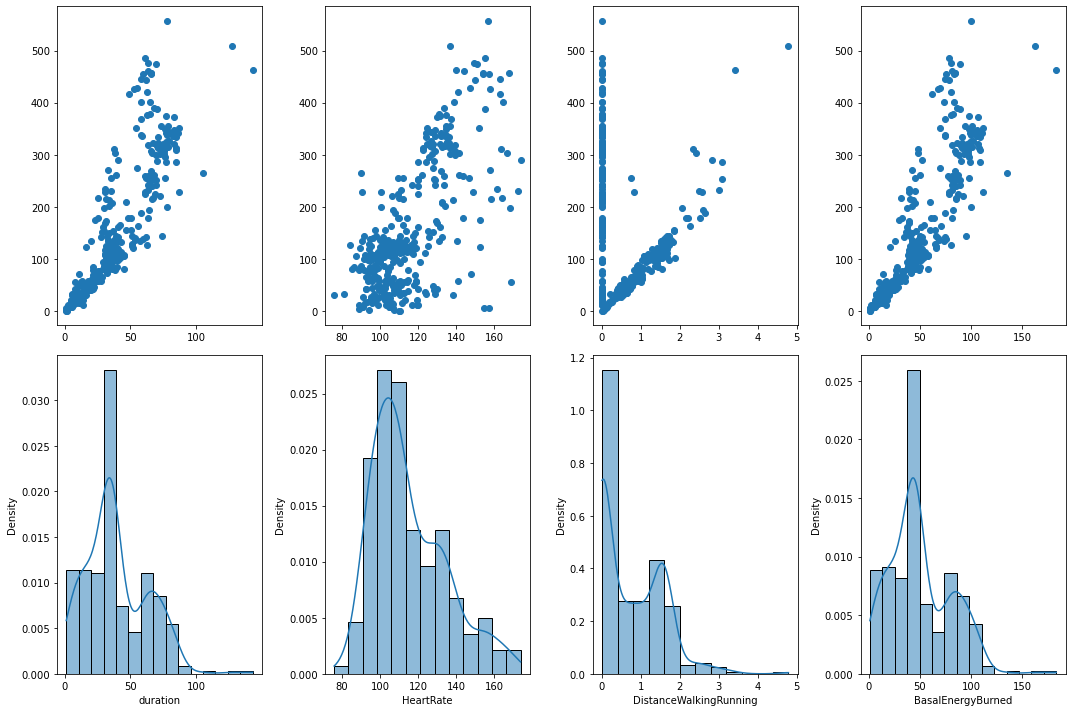

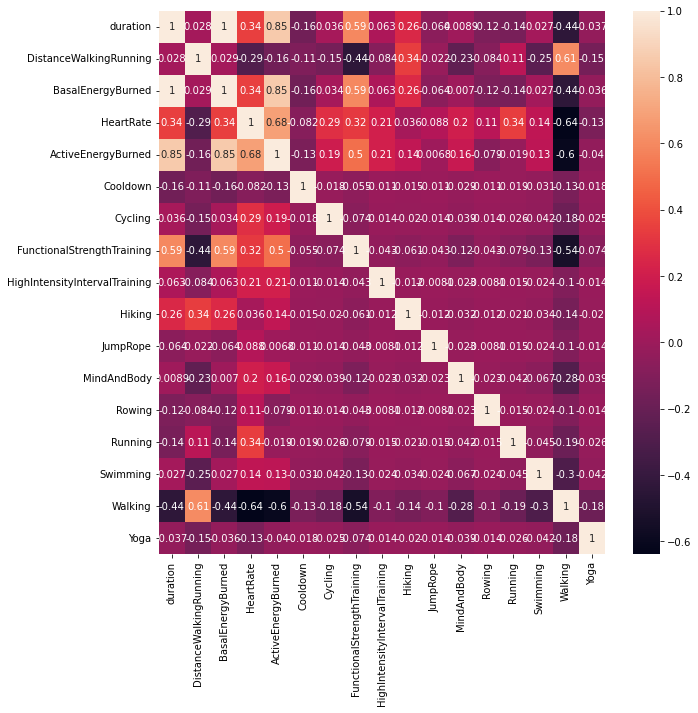

In [123]:
# Check relationship between continuous features and target variables
continuous_features = ['duration', 'HeartRate', 'DistanceWalkingRunning', 'BasalEnergyBurned']
feature_visualization(continuous_features, data=final_workout_df, target='ActiveEnergyBurned')

Based on the feature correlation heatmap, JumpRope, Rowing, Running, and Yoga are not as correlated with ActiveEnergyBurned, so I am removing those features. Additionally, duration and BasalEnergyBurned are highly correlated. As duration appears to be slightly more correlated with other features, I will remove it from my features list.

In [124]:
# Feature selection where correlation with ActiveEnergyBurned is less than workout_corr
corr_values = final_workout_df.corr()['ActiveEnergyBurned'].abs()
target_corr = corr_values.index[corr_values <= workout_corr].tolist()

# Remove features that are highly correlated + target variable
redundant_var = ['duration']
features = final_workout_df.drop(['Date', 'ActiveEnergyBurned'] + redundant_var + target_corr, axis=1) 

# Model fitting
find_best_model(features, output=final_workout_df['ActiveEnergyBurned'], models=models)

------------------Daily Basal Energy Expenditure---------------------

LinearRegression() : 
Training Error :  20.842247471860553
Validation Error :  27.476228559457383

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) : 
Training Error :  0.15013921749286058
Validation Error :  17.825272890585058

La